# Copyright Netherlands eScience Center <br>
** Function     : Evaluation of AMET computed with FD, SH and residuals (spatial pattern)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.07.24 ** <br>
** Last Update  : 2019.07.24 ** <br>
Description  : This script serves to evaluate AMET computed with different methods. The sensitivity of AMET to baratropic mass budget correction via finite difference and spherical harmonics are included here. <br>

It also serves to calculate the meridional energy transport in the atmosphere as the residual of net radiation flux at top of the atmosphere and the net surface flux at the sea surface. The fields are estimated from ERA-Interim.<br>
Return Values : jpeg <br>
Caveat!         : The AMET is computed as the residual of net flux at TOA and surface. <br>
For all the flux generated by ECMWF model, **downward is positive** (regardless of the standard name). So it is with **ERA-Interim** <br>
While for the flux in **MERRA2**, the **positive sign** for each variable varies:<br>
* Net shortwave radiation at surface - downward <br>
* Net shortwave radiation at TOA - downward <br>
* Net longwave radiation at surface - downward <br>
* Upwelling longwave radiation at TOA - upward <br>
* Total latent energy flux - upward <br>
* Sensible heat flux - upward <br>

While for the flux in **JRA55**, the **positive sign** for each variable varies:<br>
* Latent heat flux - upward <br>
* Sensible heat flux - upward <br>
* Downward solar radiation flux at TOA - downward <br>
* Downward solar radiation flux at surface - downward <br>
* Downward longwave radiation flux at surface - downward <br>
* Upward solar radiation flux at TOA - upward <br>
* Upward solar radiation flux at surface - upward <br>
* Upward longwave radiation flux at TOA - upward <br>
* Upward longwave radiation flux at surface - upward <br>

Here we use the net radiation flux of JRA55 after post-processing, as follows: <br>
* Net radiation at TOA - downward <br>
* Net radiation at surface - downward <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer
from scipy import stats

import matplotlib
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
# index of latitude for insteret
# 60N
lat_ERAI_60_FD = 40
lat_MERRA2_60_FD = 80
lat_JRA55_60_FD = 53

lat_ERAI_60_SH = 213
lat_MERRA2_60_SH = 300
lat_JRA55_60_SH = 267

In [4]:
if __name__=="__main__":
    # sample
    # SH: spherical harmonics FD: finite difference
    ################################   Input zone  ######################################
    # specify data path
    datapath_ERAI_AMET_FD = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    #datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ERAI_AMET_SH = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
    datapath_MERRA2_AMET_FD = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
    #datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_AMET_FD = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
    #datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
    datapath_JRA55_AMET_SH = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/dataExpo/AMET_res_div'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_AMET_FD = Dataset(os.path.join(datapath_ERAI_AMET_FD,
                                   'era_model_subdaily_1979_2016_amet_FD.nc'))
    dataset_ERAI_AMET_SH = Dataset(os.path.join(datapath_ERAI_AMET_SH,
                                   'era_model_subdaily_1979_2017_amet_SH.nc'))
    dataset_MERRA2_AMET_FD = Dataset(os.path.join(datapath_MERRA2_AMET_FD,
                                     'AMET_MERRA2_model_daily_1980_2016_E_point.nc'))
    dataset_JRA55_AMET_FD = Dataset(os.path.join(datapath_JRA55_AMET_FD,
                                    'AMET_JRA55_model_daily_1979_2015_E_point.nc'))
    dataset_JRA55_AMET_SH = Dataset(os.path.join(datapath_JRA55_AMET_SH,
                                    'jra_model_subdaily_1979_2016_amet_SH.nc'))
    dataset_JRA55_mass_SH = Dataset(os.path.join(datapath_JRA55_AMET_SH,
                                    'jra_model_monthly_uvc_1979_2016_SH.nc'))    
    print("Since the file size is very large, we will work with each data set seperately.")

*********************** extract variables *************************
Since the file size is very large, we will work with each data set seperately.


In [5]:
    print ('*********************** mass correction JRA55 *************************')
    mass_JRA55_FD = dataset_JRA55_AMET_FD.variables['vc'][:]
    mass_JRA55_SH = dataset_JRA55_mass_SH.variables['vc'][:]
    
    amet_JRA55_FD = dataset_JRA55_AMET_FD.variables['E'][:]
    amet_JRA55_SH = dataset_JRA55_AMET_SH.variables['E'][:]
    
    rmse_mass = np.sqrt(np.mean(np.mean((mass_JRA55_FD - mass_JRA55_SH[:-1,:,:,:])**2,0),0))
    rmse_amet = np.sqrt(np.mean(np.mean((amet_JRA55_FD - amet_JRA55_SH[:-1,:,:,:])**2,0),0))
    percent_mass = np.mean(np.mean(np.abs((mass_JRA55_FD - mass_JRA55_SH[:-1,:,:,:])
                                          / mass_JRA55_SH[:-1,:,:,:]),0),0)
    percent_amet = np.mean(np.mean(np.abs((amet_JRA55_FD - amet_JRA55_SH[:-1,:,:,:])
                                          / amet_JRA55_SH[:-1,:,:,:]),0),0)

*********************** mass correction JRA55 *************************


*********************** plot mass correction rmse JRA55 *************************


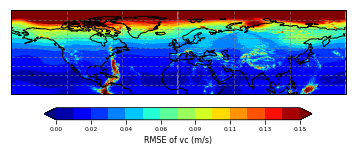

*********************** plot AMET rmse JRA55 *************************


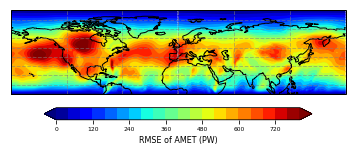

In [10]:
    latitude = dataset_JRA55_mass_SH.variables['latitude'][:]
    longitude = dataset_JRA55_mass_SH.variables['longitude'][:]
    ticks = np.linspace(0,0.15,15)
    print ('*********************** plot mass correction rmse JRA55 *************************')
    lat_iris = iris.coords.DimCoord(latitude, standard_name='latitude', long_name='latitude',
                                    var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude, standard_name='longitude', long_name='longitude',
                                    var_name='lon', units='degrees')
    # assembly the cube
    cube_iris = iris.cube.Cube(rmse_mass, long_name='geographical field', var_name='field',
                               units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)])
    fig = plt.figure(figsize=(6,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180,180,0,90],ccrs.PlateCarree())
    ax.set_aspect('1')
    ax.coastlines()
    gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    cs = iplt.contourf(cube_iris, cmap='jet',levels=ticks, extend='both') #, vmin=ticks[0], vmax=ticks[-1]
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.05, format="%.2f")
    cbar.set_label('RMSE of vc (m/s)',size = 8)
    #cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'rmse_vc_jra_FD_SH.png'), dpi=300)
    plt.close(fig)
    
    ticks = np.linspace(0,800,21)
    print ('*********************** plot AMET rmse JRA55 *************************')
    # assembly the cube
    cube_iris = iris.cube.Cube(rmse_amet, long_name='geographical field', var_name='field',
                               units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)])
    fig = plt.figure(figsize=(6,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180,180,0,90],ccrs.PlateCarree())
    ax.set_aspect('1')
    ax.coastlines()
    gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    cs = iplt.contourf(cube_iris, cmap='jet',levels=ticks, extend='both') #, vmin=ticks[0], vmax=ticks[-1]
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.05)
    cbar.set_label('RMSE of AMET (PW)',size = 8)
    #cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'rmse_amet_jra_FD_SH.png'), dpi=300)
    plt.close(fig)

In [ ]:
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # finite difference
    AMET_div_int_ERAI_FD = dataset_ERAI_AMET_FD.variables['E_total_int'][:]/1000 # from Tera Watt to Peta Watt
    AMET_div_int_MERRA2_FD = dataset_MERRA2_AMET_FD.variables['E'][:]/1000
    AMET_div_int_JRA55_FD = dataset_JRA55_AMET_FD.variables['E'][:]/1000    
    # spherical harmonics
    AMET_div_int_ERAI_SH = dataset_ERAI_AMET_SH.variables['E_int'][:]/1000 # from Tera Watt to Peta Watt
    #AMET_div_int_MERRA2_SH = dataset_MERRA2_AMET.variables['E'][:]/1000
    AMET_div_int_JRA55_SH = dataset_JRA55_AMET_SH.variables['E_int'][:]/1000        
    
    # other dimensions
    year_ERAI_FD = dataset_ERAI_AMET_FD.variables['year']     # from 1979 to 2016
    year_ERAI_SH = dataset_ERAI_AMET_SH.variables['year']     # from 1979 to 2017
    year_MERRA2_FD = dataset_MERRA2_AMET_FD.variables['year']    # from 1980 to 2016
    year_JRA55_FD = dataset_JRA55_AMET_FD.variables['year']   # from 1979 to 2016
    year_JRA55_SH = dataset_JRA55_AMET_SH.variables['year']   # from 1979 to 2016
    latitude_AMET_ERAI_FD = dataset_ERAI_AMET_FD.variables['latitude'][:]
    latitude_AMET_ERAI_SH = dataset_ERAI_AMET_SH.variables['latitude'][:]
    latitude_AMET_MERRA2_FD = dataset_MERRA2_AMET_FD.variables['latitude'][:]
    latitude_AMET_JRA55_FD = dataset_JRA55_AMET_FD.variables['latitude'][:]
    latitude_AMET_JRA55_SH = dataset_JRA55_AMET_SH.variables['latitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    # reverse the latitude of MERRA2 fields
    latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][::-1]
    longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
    latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
    longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]

In [7]:
    print ('Prepare data for plots!')
    # time series for comparison
    AMET_div_int_ERAI_FD_series = AMET_div_int_ERAI_FD.reshape(len(year_ERAI_FD)*12,
                                                               len(latitude_AMET_ERAI_FD))
    AMET_div_int_ERAI_SH_series = AMET_div_int_ERAI_SH.reshape(len(year_ERAI_SH)*12,
                                                               len(latitude_AMET_ERAI_SH))
    AMET_res_int_ERAI_series = AMET_res_ERAI.reshape(len(year_ERAI_FD)*12,
                                                     len(latitude_fields_ERAI))
    AMET_div_int_MERRA2_FD_series = AMET_div_int_MERRA2_FD.reshape(len(year_MERRA2_FD)*12,
                                                                   len(latitude_AMET_MERRA2_FD))
    AMET_res_int_MERRA2_series = AMET_res_MERRA2.reshape(len(year_MERRA2_FD)*12,
                                                         len(latitude_fields_MERRA2))
    AMET_div_int_JRA55_FD_series = AMET_div_int_JRA55_FD.reshape(len(year_JRA55_FD)*12,
                                                                 len(latitude_AMET_JRA55_FD))
    AMET_div_int_JRA55_SH_series = AMET_div_int_JRA55_SH.reshape(len(year_JRA55_SH)*12,
                                                                 len(latitude_AMET_JRA55_SH))
    AMET_res_int_JRA55_series = AMET_res_JRA55.reshape(len(year_JRA55_FD[:-2])*12,
                                                       len(latitude_fields_JRA55))

Prepare data for plots!


In [25]:
    print(latitude_AMET_ERAI_SH[156:])
    print(latitude_AMET_JRA55_SH[195:])

[19.99996  20.701714 21.403465 22.105219 22.806973 23.508724 24.210478
 24.91223  25.613983 26.315735 27.017488 27.71924  28.420994 29.122746
 29.8245   30.52625  31.228004 31.929756 32.631508 33.333263 34.035015
 34.736767 35.43852  36.14027  36.842022 37.543777 38.24553  38.94728
 39.649033 40.350784 41.052536 41.754288 42.45604  43.15779  43.859543
 44.561295 45.263046 45.964798 46.66655  47.3683   48.070053 48.771805
 49.473557 50.17531  50.87706  51.57881  52.28056  52.98231  53.684063
 54.385815 55.087563 55.789314 56.491062 57.192814 57.89456  58.596313
 59.29806  59.999813 60.70156  61.40331  62.105057 62.806805 63.508553
 64.210304 64.91205  65.61379  66.315544 67.01729  67.71903  68.42078
 69.12252  69.824265 70.52601  71.22775  71.92949  72.63123  73.33297
 74.034706 74.73644  75.43818  76.13991  76.84164  77.543365 78.245094
 78.94681  79.64853  80.350235 81.05194  81.75363  82.45532  83.15699
 83.858635 84.560265 85.26185  85.96337  86.6648   87.366066 88.06697
 88.76695  

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence 20N - 90N !@#$%^&***********


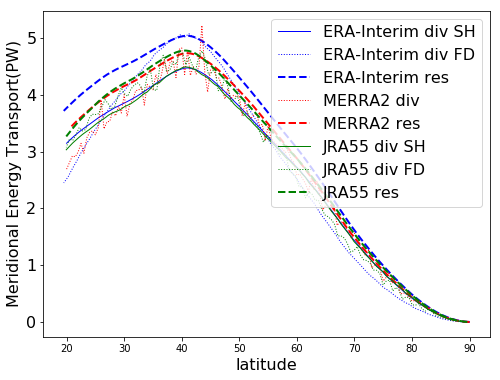

In [8]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence 20N - 90N !@#$%^&***********')
    fig1 = plt.figure()
    fig1.set_size_inches(8, 6)
    plt.plot(latitude_AMET_ERAI_SH[156:], np.mean(AMET_div_int_ERAI_SH_series[:,156:],0),'b-',
             linewidth=1.0,label='ERA-Interim div SH')    
    plt.plot(latitude_AMET_ERAI_FD, np.mean(AMET_div_int_ERAI_FD_series,0),'b:',
             linewidth=1.0,label='ERA-Interim div FD')
    plt.plot(latitude_fields_ERAI[:95], np.mean(AMET_res_int_ERAI_series[:,:95],0), 'b--',
             linewidth=2.0, label='ERA-Interim res')
    plt.plot(latitude_AMET_MERRA2_FD, np.mean(AMET_div_int_MERRA2_FD_series,0),'r:',
             linewidth=1.0,label='MERRA2 div')
    plt.plot(latitude_fields_MERRA2[:140], np.mean(AMET_res_int_MERRA2_series[:,:140],0), 'r--',
             linewidth=2.0, label='MERRA2 res')
    plt.plot(latitude_AMET_JRA55_SH[195:], np.mean(AMET_div_int_JRA55_SH_series[:,195:],0),'g-',
             linewidth=1.0,label='JRA55 div SH')
    plt.plot(latitude_AMET_JRA55_FD[:125], np.mean(AMET_div_int_JRA55_FD_series[:,:125],0),'g:',
             linewidth=1.0,label='JRA55 div FD')
    plt.plot(latitude_fields_JRA55[:125], np.mean(AMET_res_int_JRA55_series[:,:125],0), 'g--',
             linewidth=2.0, label='JRA55 res')
    plt.xlabel("latitude",fontsize=16)
   #plt.xticks(,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=1, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'AMET_res_div_SH_FD.png'),dpi=300)
    plt.close(fig1)

*******************  postprocess era *********************
***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


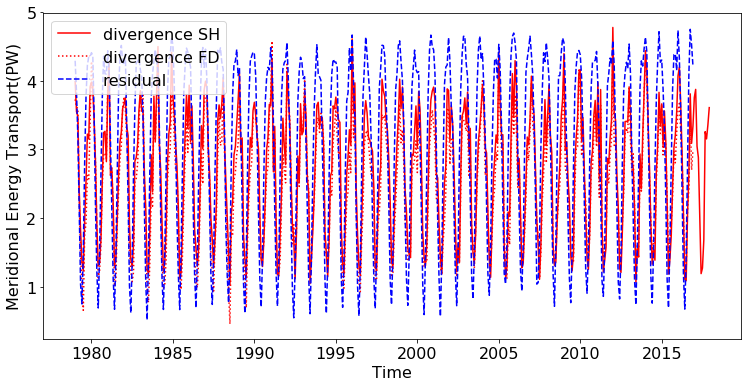

mean of divergence SH
2.7204688960670405
mean of divergence FD
2.52137809887267
mean of residual
3.0599991087937206


In [9]:
    print ('*******************  postprocess era *********************')
    print ('***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2016
    
    fig2 = plt.figure()
    fig2.set_size_inches(12.5, 6)
    plt.plot(index[:], AMET_div_int_ERAI_SH_series[:,213],'r-',
             linewidth=1.5,label='divergence SH')
    plt.plot(index[:-12], AMET_div_int_ERAI_FD_series[:,40],'r:',
             linewidth=1.5,label='divergence FD')
    plt.plot(index[:-12], AMET_res_int_ERAI_series[:,40],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig2.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_60N_era.png'),dpi=300)
    plt.close(fig2)
    # statistics
    print('mean of divergence SH')
    print(np.mean(AMET_div_int_ERAI_SH_series[:,213]))
    print('mean of divergence FD')
    print(np.mean(AMET_div_int_ERAI_FD_series[:,40]))
    print('mean of residual')
    print(np.mean(AMET_res_int_ERAI_series[:,40]))

*******************  postprocess merra *********************
***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


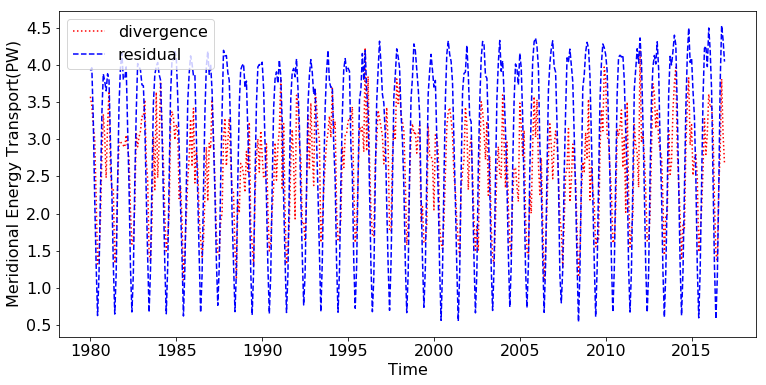

mean of divergence FD
2.5806875596456087
mean of residual
2.878948342454463


In [10]:
    print ('*******************  postprocess merra *********************')
    print ('***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig21 = plt.figure()
    fig21.set_size_inches(12.5, 6)
    plt.plot(index[12:], AMET_div_int_MERRA2_FD_series[:,80],'r:',
             linewidth=1.5,label='divergence')
    plt.plot(index[12:], AMET_res_int_MERRA2_series[:,60],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig21.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_60N_merra.png'),dpi=300)
    plt.close(fig21)
    # statistics
    print('mean of divergence FD')
    print(np.mean(AMET_div_int_MERRA2_FD_series[:,80]))
    print('mean of residual')
    print(np.mean(AMET_res_int_MERRA2_series[:,60]))

*******************  postprocess jra *********************
***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


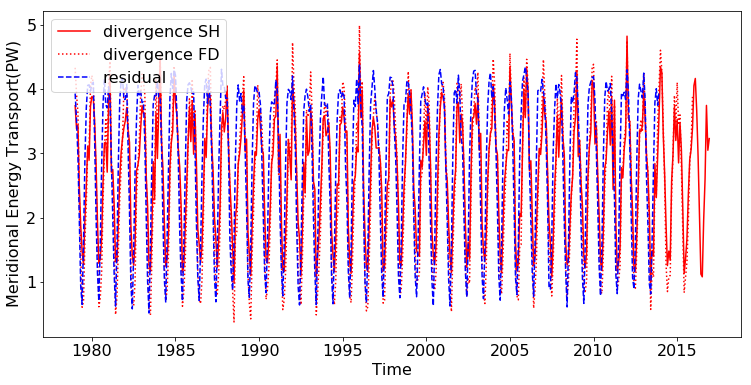

mean of divergence SH
2.6761196203399122
mean of divergence
2.5631246127481893
mean of residual
2.8967026086335212


In [11]:
    print ('*******************  postprocess jra *********************')
    print ('***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig22 = plt.figure()
    fig22.set_size_inches(12.5, 6)
    plt.plot(index[:], AMET_div_int_JRA55_SH_series[:,267],'r-',
             linewidth=1.5,label='divergence SH')
    plt.plot(index[:-12], AMET_div_int_JRA55_FD_series[:,53],'r:',
             linewidth=1.5,label='divergence FD')
    plt.plot(index[:-36], AMET_res_int_JRA55_series[:,53],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig22.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_60N_jra.png'),dpi=300)
    plt.close(fig22)
    # statistics
    print('mean of divergence SH')
    print(np.mean(AMET_div_int_JRA55_SH_series[:,267]))
    print('mean of divergence')
    print(np.mean(AMET_div_int_JRA55_FD_series[:,53]))
    print('mean of residual')
    print(np.mean(AMET_res_int_JRA55_series[:,53]))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


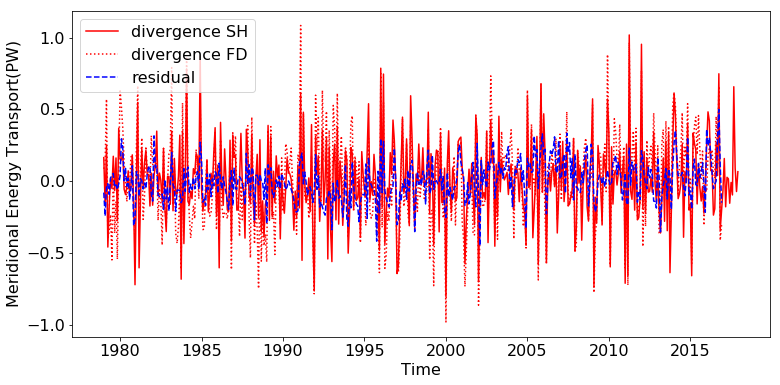

std of divergence SH
0.27977418569683715
std of divergence FD
0.3198688764850559
std of residual
0.1402194915898489


In [12]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_ERAI_SH = meta.statistics.operator(AMET_div_int_ERAI_SH_series[:,213])
    stat_AMET_div_ERAI_SH.anomaly(Dim_month=False)
    stat_AMET_div_ERAI_FD = meta.statistics.operator(AMET_div_int_ERAI_FD_series[:,40])
    stat_AMET_div_ERAI_FD.anomaly(Dim_month=False)
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    
    fig3 = plt.figure()
    fig3.set_size_inches(12.5, 6)
    plt.plot(index[:], stat_AMET_div_ERAI_SH._anomaly,'r-',
             linewidth=1.5,label='divergence SH')
    plt.plot(index[:-12], stat_AMET_div_ERAI_FD._anomaly,'r:',
             linewidth=1.5,label='divergence FD')
    plt.plot(index[:-12], stat_AMET_res_ERAI._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig3.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_anomaly_60N_era.png'),dpi=300)
    plt.close(fig3)
    # statistics
    print('std of divergence SH')
    print(np.std(stat_AMET_div_ERAI_SH._anomaly))
    print('std of divergence FD')
    print(np.std(stat_AMET_div_ERAI_FD._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_ERAI._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


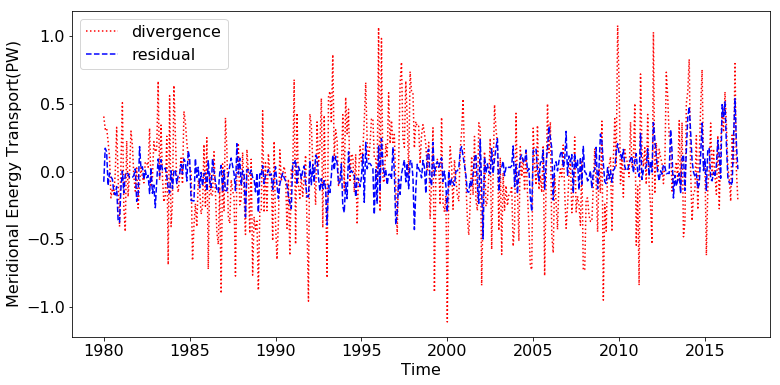

std of divergence FD
0.35275539025415875
std of residual
0.13860082237620933


In [13]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_MERRA2_FD = meta.statistics.operator(AMET_div_int_MERRA2_FD_series[:,80])
    stat_AMET_div_MERRA2_FD.anomaly(Dim_month=False)
    stat_AMET_res_MERRA2 = meta.statistics.operator(AMET_res_int_MERRA2_series[:,60])
    stat_AMET_res_MERRA2.anomaly(Dim_month=False)    
    
    fig31 = plt.figure()
    fig31.set_size_inches(12.5, 6)
    plt.plot(index[12:], stat_AMET_div_MERRA2_FD._anomaly,'r:',
             linewidth=1.5,label='divergence')
    plt.plot(index[12:], stat_AMET_res_MERRA2._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig31.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_anomaly_60N_merra.png'),dpi=300)
    plt.close(fig31)
    # statistics
    print('std of divergence FD')
    print(np.std(stat_AMET_div_MERRA2_FD._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_MERRA2._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


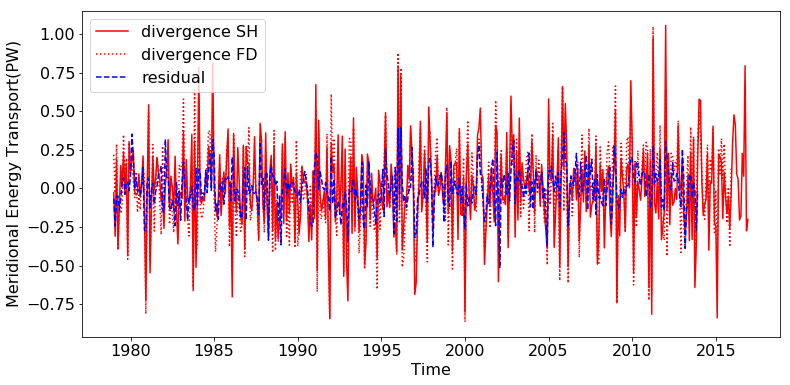

std of divergence SH
0.2849468499530294
std of divergence FD
0.2856719528830702
std of residual
0.1357584097236335


In [14]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_JRA55_SH = meta.statistics.operator(AMET_div_int_JRA55_SH_series[:,267])
    stat_AMET_div_JRA55_SH.anomaly(Dim_month=False)
    stat_AMET_div_JRA55_FD = meta.statistics.operator(AMET_div_int_JRA55_FD_series[:,53])
    stat_AMET_div_JRA55_FD.anomaly(Dim_month=False)
    stat_AMET_res_JRA55 = meta.statistics.operator(AMET_res_int_JRA55_series[:,53])
    stat_AMET_res_JRA55.anomaly(Dim_month=False)
    
    fig32 = plt.figure()
    fig32.set_size_inches(12.5, 6)
    plt.plot(index[:], stat_AMET_div_JRA55_SH._anomaly,'r-',
             linewidth=1.5,label='divergence SH')
    plt.plot(index[:-12], stat_AMET_div_JRA55_FD._anomaly,'r:',
             linewidth=1.5,label='divergence FD')
    plt.plot(index[:-36], stat_AMET_res_JRA55._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig32.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_anomaly_60N_jra.png'),dpi=300)
    plt.close(fig32)
    # statistics
    print('std of divergence SH')
    print(np.std(stat_AMET_div_JRA55_SH._anomaly))
    print('std of divergence FD')
    print(np.std(stat_AMET_div_JRA55_FD._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_JRA55._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input 

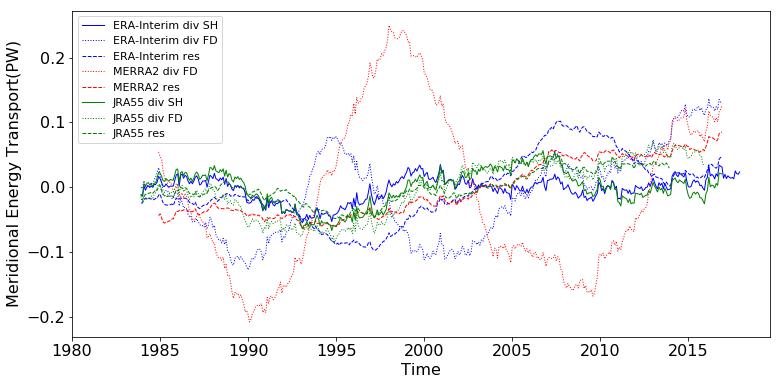

std of divergence SH - ERAI
0.019050179378063872
std of divergence FD - ERAI
0.06799931657497507
std of residual - ERAI
0.05109024224636256
std of divergence FD - MERRA2
0.12159324028174026
std of residual - MERRA2
0.043668578694791044
std of divergence SH - JRA55
0.04269698402282107
std of divergence FD - JRA55
0.028108366540892254
std of residual - JRA55
0.024627013270788808
Correlation AMET-Divergence SH ERAI & JRA55
0.7593077822871013
Correlation AMET-Divergence FD ERAI & MERRA2
0.1835164180568071
Correlation AMET-Divergence FD ERAI & JRA55
0.3066710187795962
Correlation AMET-Residual ERAI & MERRA2
0.8381488214512742
Correlation AMET-Residual ERAI & JRA55
0.9227091279678201


In [17]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI_SH[-1]+1,5)
    index = np.arange(1,469,1) # 1979 - 2017
    # take anomalies
    stat_AMET_div_ERAI_SH = meta.statistics.operator(AMET_div_int_ERAI_SH_series[:,213])
    stat_AMET_div_ERAI_SH.anomaly(Dim_month=False)
    stat_AMET_div_ERAI_SH.lowpass()

    stat_AMET_div_ERAI_FD = meta.statistics.operator(AMET_div_int_ERAI_FD_series[:,40])
    stat_AMET_div_ERAI_FD.anomaly(Dim_month=False)
    stat_AMET_div_ERAI_FD.lowpass()
    
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    stat_AMET_res_ERAI.lowpass()
    
    stat_AMET_div_MERRA2_FD = meta.statistics.operator(AMET_div_int_MERRA2_FD_series[:,80])
    stat_AMET_div_MERRA2_FD.anomaly(Dim_month=False)
    stat_AMET_div_MERRA2_FD.lowpass()
    
    stat_AMET_res_MERRA2 = meta.statistics.operator(AMET_res_int_MERRA2_series[:,60])
    stat_AMET_res_MERRA2.anomaly(Dim_month=False)
    stat_AMET_res_MERRA2.lowpass()

    stat_AMET_div_JRA55_SH = meta.statistics.operator(AMET_div_int_JRA55_SH_series[:,267])
    stat_AMET_div_JRA55_SH.anomaly(Dim_month=False)
    stat_AMET_div_JRA55_SH.lowpass()

    stat_AMET_div_JRA55_FD = meta.statistics.operator(AMET_div_int_JRA55_FD_series[:,53])
    stat_AMET_div_JRA55_FD.anomaly(Dim_month=False)
    stat_AMET_div_JRA55_FD.lowpass()
    
    stat_AMET_res_JRA55 = meta.statistics.operator(AMET_res_int_JRA55_series[:,53])
    stat_AMET_res_JRA55.anomaly(Dim_month=False)
    stat_AMET_res_JRA55.lowpass()
    
    fig4 = plt.figure()
    fig4.set_size_inches(12.5, 6)
    plt.plot(index[59:], stat_AMET_div_ERAI_SH._lowpass,'b-',
             linewidth=1.0,label='ERA-Interim div SH')
    plt.plot(index[59:-12], stat_AMET_div_ERAI_FD._lowpass,'b:',
             linewidth=1.0,label='ERA-Interim div FD')
    plt.plot(index[59:-12], stat_AMET_res_ERAI._lowpass,
             'b--', linewidth=1.0, label='ERA-Interim res')
    plt.plot(index[71:-12], stat_AMET_div_MERRA2_FD._lowpass,'r:',
             linewidth=1.0,label='MERRA2 div FD')
    plt.plot(index[71:-12], stat_AMET_res_MERRA2._lowpass,
             'r--', linewidth=1.0, label='MERRA2 res')
    plt.plot(index[59:-12], stat_AMET_div_JRA55_SH._lowpass,'g-',
             linewidth=1.0,label='JRA55 div SH')
    plt.plot(index[59:-24], stat_AMET_div_JRA55_FD._lowpass,'g:',
             linewidth=1.0,label='JRA55 div FD')
    plt.plot(index[59:-48], stat_AMET_res_JRA55._lowpass,
             'g--', linewidth=1.0, label='JRA55 res')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI_SH)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 11})
    plt.show()
    fig4.savefig(os.path.join(output_path,'AMET_res_div_SH_FD_anomaly_lowpass_5y_60N.png'),dpi=300)
    plt.close(fig4)
    # statistics
    print('std of divergence SH - ERAI')
    print(np.std(stat_AMET_div_ERAI_SH._lowpass))
    print('std of divergence FD - ERAI')
    print(np.std(stat_AMET_div_ERAI_FD._lowpass))
    print('std of residual - ERAI')
    print(np.std(stat_AMET_res_ERAI._lowpass))
    print('std of divergence FD - MERRA2')
    print(np.std(stat_AMET_div_MERRA2_FD._lowpass))
    print('std of residual - MERRA2')
    print(np.std(stat_AMET_res_MERRA2._lowpass))
    print('std of divergence SH - JRA55')
    print(np.std(stat_AMET_div_JRA55_FD._lowpass))
    print('std of divergence FD - JRA55')
    print(np.std(stat_AMET_div_JRA55_SH._lowpass))
    print('std of residual - JRA55')
    print(np.std(stat_AMET_res_JRA55._lowpass))
    print("======================================================================")
#     print ('Correlation AMET-Divergence SH ERAI & MERRA2')
#     _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_MERRA2_FD._lowpass,
#                                                  stat_AMET_div_ERAI_FD._lowpass[12:])
    print ('Correlation AMET-Divergence SH ERAI & JRA55')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_JRA55_SH._lowpass,
                                                 stat_AMET_div_ERAI_SH._lowpass[:-12])
    print (Corr_AMET_Res)
    print ('Correlation AMET-Divergence FD ERAI & MERRA2')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_MERRA2_FD._lowpass,
                                                 stat_AMET_div_ERAI_FD._lowpass[12:])
    print (Corr_AMET_Res)
    print ('Correlation AMET-Divergence FD ERAI & JRA55')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_JRA55_FD._lowpass,
                                                 stat_AMET_div_ERAI_FD._lowpass[:-12])
    print (Corr_AMET_Res)    
    print ('Correlation AMET-Residual ERAI & MERRA2')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_res_MERRA2._lowpass,
                                                 stat_AMET_res_ERAI._lowpass[12:])
    print (Corr_AMET_Res)
    print ('Correlation AMET-Residual ERAI & JRA55')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_res_JRA55._lowpass,
                                                 stat_AMET_res_ERAI._lowpass[:-36])
    print (Corr_AMET_Res)    